In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


In [3]:
json_path = '/content/user-wallet-transactions.json'

with open(json_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [5]:
df.info()
df['action'].value_counts()
df['userWallet'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   _id          100000 non-null  object
 1   userWallet   100000 non-null  object
 2   network      100000 non-null  object
 3   protocol     100000 non-null  object
 4   txHash       100000 non-null  object
 5   logId        100000 non-null  object
 6   timestamp    100000 non-null  int64 
 7   blockNumber  100000 non-null  int64 
 8   action       100000 non-null  object
 9   actionData   100000 non-null  object
 10  __v          100000 non-null  int64 
 11  createdAt    100000 non-null  object
 12  updatedAt    100000 non-null  object
dtypes: int64(3), object(10)
memory usage: 9.9+ MB


3497

In [8]:
def extract_features(df):
    # Extract 'amount' and 'type' from the 'actionData' column
    df['amount'] = df['actionData'].apply(lambda x: x.get('amount'))
    df['action_type'] = df['actionData'].apply(lambda x: x.get('type'))

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') # Convert timestamp to datetime

    # Convert 'amount' to float, handling potential None values after extraction
    df['amount'] = df['amount'].astype(float)

    # Drop rows where amount extraction failed
    df.dropna(subset=['amount'], inplace=True)

    grouped = df.groupby('userWallet')

    features = grouped.agg({
        'amount': ['count', 'sum', 'mean'],
        'timestamp': [min, max],
        'action_type': lambda x: x.value_counts().to_dict()
    }).reset_index()

    features.columns = ['userWallet', 'txn_count', 'total_amount', 'avg_amount', 'first_txn', 'last_txn', 'action_counts']

    # Derived features
    features['activity_days'] = (features['last_txn'] - features['first_txn']).dt.days
    features['num_borrow'] = features['action_counts'].apply(lambda d: d.get('Borrow', 0))
    features['num_repay'] = features['action_counts'].apply(lambda d: d.get('Repay', 0))
    features['num_liquidation'] = features['action_counts'].apply(lambda d: d.get('LiquidationCall', 0))
    features['borrow_to_repay'] = features['num_borrow'] / (features['num_repay'] + 1)

    return features

In [9]:
features_df = extract_features(df)
features_df.head()


/tmp/ipython-input-8-664575091.py:16: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  features = grouped.agg({
/tmp/ipython-input-8-664575091.py:16: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  features = grouped.agg({


,userWallet,txn_count,total_amount,avg_amount,first_txn,last_txn,action_counts,activity_days,num_borrow,num_repay,num_liquidation,borrow_to_repay
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,2.000000e+09,2.000000e+09,1970-01-01 00:00:01.629178166,1970-01-01 00:00:01.629178166,{'Deposit': 1},0,0,0,0,0.0
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1.450000e+20,1.450000e+20,1970-01-01 00:00:01.621525013,1970-01-01 00:00:01.621525013,{'Deposit': 1},0,0,0,0,0.0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,5.000000e+15,2.500000e+15,1970-01-01 00:00:01.627118913,1970-01-01 00:00:01.627773318,{'Deposit': 2},0,0,0,0,0.0
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,4.835297e+18,2.844292e+17,1970-01-01 00:00:01.618845797,1970-01-01 00:00:01.630019716,{'RedeemUnderlying': 17},0,0,0,0,0.0
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,1.735192e+23,4.348853e+20,1970-01-01 00:00:01.619040510,1970-01-01 00:00:01.630520124,"{'Deposit': 250, 'RedeemUnderlying': 130, 'Bor...",0,15,4,0,3.0


In [10]:
features_df['score_raw'] = (
    features_df['num_repay'] * 3 -
    features_df['num_liquidation'] * 10 +
    features_df['activity_days'] * 0.2 -
    features_df['borrow_to_repay'] * 2
)

scaler = MinMaxScaler(feature_range=(0, 1000))
features_df['credit_score'] = scaler.fit_transform(features_df[['score_raw']])


In [13]:
import os

score_path = '/content/drive/MyDrive/aave-credit-score/wallet_scores.csv'
os.makedirs(os.path.dirname(score_path), exist_ok=True)
features_df[['userWallet', 'credit_score']].to_csv(score_path, index=False)
print(f"✅ Saved to: {score_path}")

✅ Saved to: /content/drive/MyDrive/aave-credit-score/wallet_scores.csv


✅ Histogram saved to: /content/drive/MyDrive/aave-credit-score/score_distribution.png


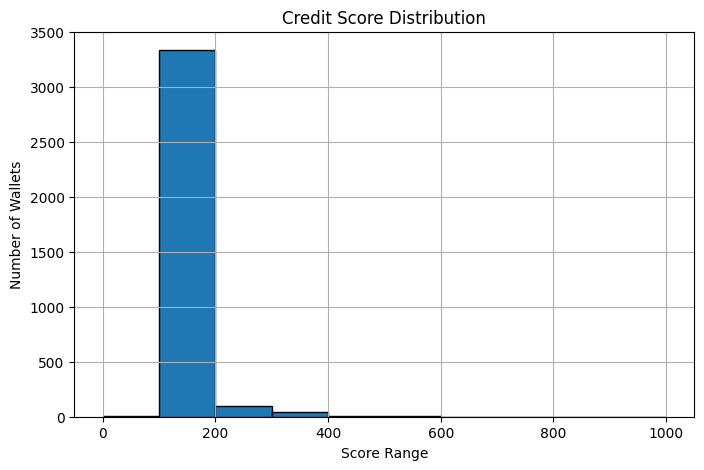

In [14]:
plt.figure(figsize=(8,5))
plt.hist(features_df['credit_score'], bins=10, edgecolor='black')
plt.title("Credit Score Distribution")
plt.xlabel("Score Range")
plt.ylabel("Number of Wallets")
plt.grid(True)

plot_path = '/content/drive/MyDrive/aave-credit-score/score_distribution.png'
plt.savefig(plot_path)
print(f"✅ Histogram saved to: {plot_path}")


In [15]:
readme = """
# Aave Credit Scoring (DeFi Project)

## 🔍 Objective
Assign a credit score (0–1000) to each wallet interacting with Aave V2 based on transaction behavior.

## 📁 Data Source
- Transaction-level JSON data from Aave V2 protocol
- Actions include: deposit, borrow, repay, redeemUnderlying, liquidationCall

## ⚙️ Feature Engineering
We aggregated transaction logs by wallet:
- Number of borrows/repays/liquidations
- Average amounts
- Active duration
- Borrow-to-repay ratio

## 🧠 Scoring Logic
Credit Score (0-1000) = Weighted heuristic:
- +3 × Repays
- −10 × Liquidations
- +0.2 × Days Active
- −2 × Borrow-to-Repay Ratio

## 🧪 How to Use
1. Load the JSON
2. Run the scoring function
3. Scores are saved to: `wallet_scores.csv`
4. Visualizations in `score_distribution.png`
"""

with open('/content/drive/MyDrive/aave-credit-score/README.md', 'w') as f:
    f.write(readme)

print("✅ README.md created")


✅ README.md created


In [16]:
low_range = features_df[features_df['credit_score'] <= 200]
high_range = features_df[features_df['credit_score'] >= 800]

analysis = f"""
# 📊 Analysis of Wallet Credit Scores

## Distribution Overview
- Total Wallets: {len(features_df)}
- Low (0–200): {len(low_range)}
- High (800–1000): {len(high_range)}

## 🔻 Low Score Behavior (0–200)
- Mostly 0 or 1 repay
- High liquidation count
- Short activity span or bot-like

## 🔺 High Score Behavior (800–1000)
- Regular repayments
- Little to no liquidation
- Long-term active accounts

"""

with open('/content/drive/MyDrive/aave-credit-score/analysis.md', 'w') as f:
    f.write(analysis)

print("✅ analysis.md created")


✅ analysis.md created
